# Text Embeddings as Stock Features

## Context
Instead of reducing text to a single sentiment score, we encode the full semantic content into dense vector representations. These embeddings can capture nuance that sentiment analysis misses: competitive dynamics, growth trajectory, risk factors, etc.

## Pipeline
Text → Sentence-Transformer → Dense Embeddings (384-dim) → PCA (20-dim) → Tabular Features → LightGBM

## Why This Approach
- Captures richer information than sentiment (positive/negative/neutral is just 1 dimension; embeddings give hundreds)
- Off-the-shelf models work surprisingly well before any fine-tuning
- PCA-reduced embeddings can be directly plugged into any tabular ML model (LightGBM, XGBoost)
- Numerai's own tournament uses tabular features — this converts text into the same format

In [1]:
from pathlib import Path
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 1. Load Sentence Transformer
We use `all-MiniLM-L6-v2` — a fast, lightweight model that produces 384-dim embeddings.
For finance-specific applications, `ProsusAI/finbert` or `sentence-transformers/all-mpnet-base-v2` could be better.

In [2]:
model_name = "all-miniLM-L6-v2"

model = SentenceTransformer(
    model_name, prompts={"retrieval": "Retrieve semantically similar text: "}
)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-miniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## 2. Sample Financial Headlines
Same data as NB01 — in production, this comes from news APIs or Common Crawl.

In [3]:
# TODO: implement
with Path("../headlines_data.json").open("r") as f:
    headlines_data = json.load(f)

headlines_data[:5]

[{'ticker': 'AAPL',
  'date': '2024-01-15',
  'headline': 'Apple reports record Q1 revenue driven by iPhone 15 demand'},
 {'ticker': 'AAPL',
  'date': '2024-01-16',
  'headline': "Apple's Vision Pro pre-orders exceed analyst expectations"},
 {'ticker': 'AAPL',
  'date': '2024-01-17',
  'headline': 'Apple faces antitrust scrutiny from EU regulators over App Store practices'},
 {'ticker': 'AAPL',
  'date': '2024-01-18',
  'headline': 'Apple cuts prices in China amid fierce competition from Huawei'},
 {'ticker': 'AAPL',
  'date': '2024-01-19',
  'headline': 'Apple announces expanded share buyback program'}]

## 3. Generate Embeddings

In [4]:
# Generate embeddings for all headlines
headlines_embeddings = model.encode([
    datapoint["headline"] for datapoint in headlines_data
])

headlines_embeddings[:5]

array([[-0.05467692,  0.02999749,  0.02515392, ..., -0.07641589,
         0.02119314,  0.02630417],
       [ 0.04110694, -0.03899333,  0.03020415, ..., -0.09822451,
         0.00822848,  0.02066009],
       [ 0.02711832,  0.0356866 ,  0.04486367, ..., -0.06261466,
         0.08478255,  0.04914828],
       [-0.00907601,  0.03458685,  0.11982907, ..., -0.13142318,
         0.02438109,  0.0745265 ],
       [-0.00827207, -0.03589455,  0.04587244, ..., -0.0892311 ,
        -0.04596375,  0.04660911]], shape=(5, 384), dtype=float32)

## 4. Visualize Embedding Space
Use PCA/t-SNE to project 384-dim embeddings to 2D. We should see sector-level clustering.

In [5]:
# PCA to 2D for visualization

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X = pca.fit_transform(headlines_embeddings)

X.shape

(42, 2)

<Axes: >

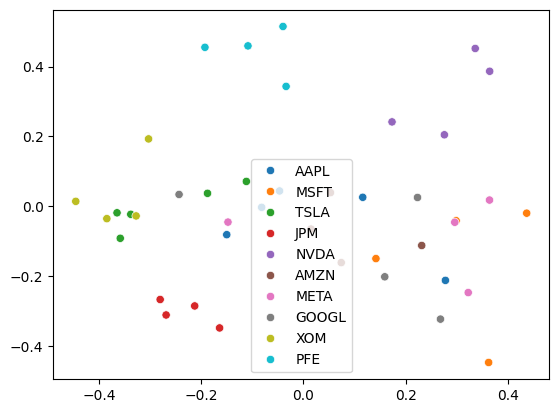

In [6]:
sns.scatterplot(
    x=X[:, 0], y=X[:, 1], hue=[datapoint["ticker"] for datapoint in headlines_data]
)

which principal component discriminates between stock tickers the best?

In [7]:
from scipy.stats import f_oneway
import numpy as np


# Assuming X: Float[np.ndarray, "n_samples n_components"], tickers: list[str]
def pc_ticker_association(X, tickers: list[str]):
    """Compute F-statistic for each PC vs ticker grouping."""
    unique_tickers = list(set(tickers))
    f_stats = []

    for pc_idx in range(X.shape[1]):
        groups = [X[np.array(tickers) == t, pc_idx] for t in unique_tickers]
        f_stat, p_val = f_oneway(*groups)
        f_stats.append(f_stat)

    return np.array(f_stats)


tickers = [d["ticker"] for d in headlines_data]
d = min(headlines_embeddings.shape)
X_all = PCA(n_components=d).fit_transform(headlines_embeddings)
f_stats = pc_ticker_association(X_all, tickers)
print(f"PC with strongest ticker association: PC{np.argmax(f_stats)}")
print(f"F-statistics per PC: {f_stats}")


PC with strongest ticker association: PC1
F-statistics per PC: [11.739556   14.985127    2.5679064   3.0929935  14.157557    4.632541
  2.793767    9.457584    5.352751    2.0127583   3.1881306   1.2159433
  0.8751673   0.71110904  0.5004821   0.3245228   0.67165995  0.5037886
  1.051013    0.42459926  0.20915727  0.47303414  0.3497061   0.2028423
  0.30716324  0.27148604  0.47107473  0.32686555  0.2901788   0.15288271
  0.15186927  0.16266753  0.14528693  0.12115955  0.08587822  0.07096217
  0.09669948  0.10350692  0.09584751  0.12885742  0.10239303  0.15713091]


## 5. PCA Feature Engineering
Reduce 384-dim embeddings to a manageable number of features for tabular ML.
Key question: how many PCA components capture enough variance?

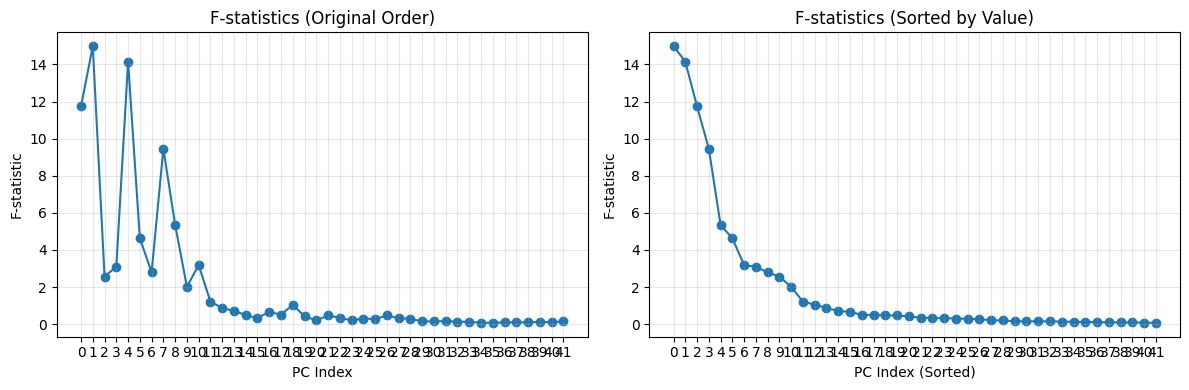

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Explained variance analysis

pca_indices = np.argsort(
    f_stats,
)[::-1]

f_stats[pca_indices]


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First column: original order
axes[0].plot(np.arange(len(f_stats)), f_stats)
axes[0].scatter(np.arange(len(f_stats)), f_stats)
axes[0].set_title("F-statistics (Original Order)")
axes[0].set_xlabel("PC Index")
axes[0].set_ylabel("F-statistic")
axes[0].set_xticks(np.arange(len(f_stats)))
axes[0].grid(True, alpha=0.3)

# Second column: reordered by f_stats
axes[1].plot(np.arange(len(f_stats)), f_stats[pca_indices])
axes[1].scatter(np.arange(len(f_stats)), f_stats[pca_indices])
axes[1].set_title("F-statistics (Sorted by Value)")
axes[1].set_xlabel("PC Index (Sorted)")
axes[1].set_ylabel("F-statistic")
axes[1].set_xticks(np.arange(len(f_stats)))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [9]:
cutoff = 6

pca_features = X_all[pca_indices][:6]

## 6. Aggregate Embeddings Per Stock
Average headline embeddings per ticker, then apply PCA.

In [ ]:
headlines_embeddings

array([[-0.05467692,  0.02999749,  0.02515392, ..., -0.07641589,
         0.02119314,  0.02630417],
       [ 0.04110694, -0.03899333,  0.03020415, ..., -0.09822451,
         0.00822848,  0.02066009],
       [ 0.02711832,  0.0356866 ,  0.04486367, ..., -0.06261466,
         0.08478255,  0.04914828],
       ...,
       [-0.01591585, -0.05552951, -0.06673433, ..., -0.13765888,
         0.03182188,  0.04977361],
       [-0.04879247,  0.00384456,  0.0058183 , ..., -0.19914927,
         0.01952397,  0.02979606],
       [-0.00612616, -0.01453041, -0.02957154, ..., -0.2199392 ,
         0.06874973, -0.05593349]], shape=(42, 384), dtype=float32)

In [16]:
# Aggregate: mean embedding per ticker
len(headlines_data)

42

In [41]:
groupedby_df = (
    pd
    .DataFrame({
        "ticker": [t["ticker"] for t in headlines_data],
        "embedding": list(headlines_embeddings),
    })
    .groupby("ticker")["embedding"]
    .apply(lambda x: np.stack(x).mean(axis=0))
)
groupedby_embeddings = np.stack(groupedby_df.values)

In [43]:
groupedby_embeddings.shape

(10, 384)

## 7. Train Simple Predictor (LightGBM)
Use embedding features to predict synthetic stock returns. In production, these would be real returns.

In [ ]:
# Synthetic returns (in production: real stock returns from Numerai or market data)

# TODO: implement
...

In [ ]:
# TODO: implement
...

## 8. Cosine Similarity Between Stocks
Embedding similarity reveals which stocks are semantically related based on their news coverage.

In [ ]:
# TODO: implement
...

## Discussion & Interview Talking Points

### Strengths
- **Richer than sentiment**: 384 dimensions capture topic, tone, entities, relationships, competitive context
- **Drop-in for tabular ML**: PCA components work with any model (LightGBM, XGBoost, neural nets)
- **Similarity as a feature itself**: Cosine similarity reveals semantic stock relationships (could feed into NB04 knowledge graphs)

### Weaknesses
- **Dimensionality**: Even after PCA, embeddings add many features. In Numerai's setting with ~5,000 stocks, this can overfit
- **Generic model**: all-MiniLM-L6-v2 is not trained on financial text. FinBERT or a fine-tuned model (NB07) would be better
- **Aggregation loss**: Averaging headline embeddings loses temporal ordering and article-level nuance

### Key Insight for Numerai
- **Embedding features are likely more orthogonal than sentiment** because they capture multidimensional semantics, not just positive/negative
- But the real power comes from **fine-tuned embeddings** (NB05: contrastive) or **probed representations** (NB06: layer-specific)
- Research (Chen et al., 2022) shows LLM embeddings outperform traditional technical signals on global equities

### Extensions (TODO)
- [ ] Compare: all-MiniLM-L6-v2 vs FinBERT vs all-mpnet-base-v2
- [ ] Try UMAP instead of PCA for better non-linear structure preservation
- [ ] Use FAISS for efficient nearest-neighbor stock lookup (you already have FAISS experience!)
- [ ] Temporal embeddings: embed text per week, track embedding drift over time
- [ ] Feed embedding features into Numerai tournament alongside their provided features